# Python 入門講座：EPICS CA  (と　Jupyter Notbook widget) 篇

# EPICS チャンネル アクセス　(CA)　モジュール(python-ca)

この文書では、EPICS の基本プロトコル チャンネル　アクセス（CA）をpythonプログラムの中で利用する一方法を紹介します。ここでは KEK で開発された Pyhon ca モジュールを使います。

EPICSは加速器など大小の実験装置をリモート制御するためのソフトウェア フレームワークの一つです。
EPICSでは制御のための通信はチャンネルアクセス(CA)と呼ばれるプロトコルが使われます。チャンネルアクセスプロトコルは標準的なIPネットワークを基本としており、さまざまな環境で簡単に利用することができます。

チャンネルアクセスプロトコルでは、その名が示す様に、一つのシステムの中で一意の名前をもつチャンネルを基本にプロトコルが構成されています。チャンネルは制御対象の一つの制御情報と関係付けられていて、最新の値(.VAL)の他に、操作の上下限値、警報値、ステータス情報などの補助的な情報を含んでいます。

EPICSのチャンネル アクセスをPythonプログラムで取り扱うためのモジュールは、KEK のCAモジュールの他にも、幾つか公表されています。KEK/KEKBで開発された Python ca モジュールおよび　cas モジュールは、長らくKEK/J-PARCで使用されており、EPICS CAをサポートするPython モジュールの中でも歴史あるモジュールの一つです。 次世代EPICSであるEPICS 7では、チャンネルアクセスに加えて、新しいネットワークプロトコル、PVアクセスが使える様になります。PythonでこのPVアクセスによるモジュールも同時に開発されており、EPICS 7が中心となった時には、PVアクセスのためのモジュール [PvaPy][pvapy]が用意されています。

[pvapy]: https://github.com/epics-base/pvaPy

## EPICS チャンネルのまとめ
PythonでEPICS チャンネルを取り扱うために必要なEPICSチャンネルについての知識をまとめておきます。
EPICSについての詳しい解説は、[J-PARC 制御グループWiki のEPICSカテゴリページ][EPICS カテゴリ] およびその中で紹介されている資料をご覧ください。

[www-cont]: http://www-cont.j-parc.jp/mediawiki/index.php/EPICS
[EPICS カテゴリ]: http://www-cont.j-parc.jp/mediawiki/index.php/%E3%82%AB%E3%83%86%E3%82%B4%E3%83%AA:EPICS


### チャンネル

* EPICSベースの制御システムにある情報はチャンネル名を通じて読み/書き/監視される。
* 全てのチャンネルはそれぞれのチャンネル名で区別される。
* チャンネル名の一般形は<レコード名>.<フィールド名>の形式である。

  * .<フィールド名>が省略された場合、それは<レコード名>.VALと解釈されます。
* 各チャンネルは固有のデータ型を持つ。

  * 整数／浮動小数点/列挙型/ストリング/それらのデータの一次元配列

### チャンネル オブジェクト

* python caモジュールでは、　各チャンネルに対して、channelオブジェクトを生成します。

  * python ca モジュールでは、チャンネルオブジェクトの生成時にチャンネルの探索が行われます。
 
    * 必要なチャンネルをどのIOCが持っているかをCAが自動的に探します。

    * 探索の範囲はEPICS_CA_ADDR_LISTなどの環境変数で変化します。通常探索には100m秒オーダーの時間がかかります。
    
    * IOC(EPICS CA サーバー）とネットワークを通して、直接通信できない計算機から、IOCのチャンネルにアクセスするためには、IOCとPCの間にCA  ゲートウェイを設置する必要があります。
  

* channel オブジェクトには、get, put, monitorの三つの基本メソッドがあります。

  * 最新の値を読み出すために、`channel.get()` を使います。
  
  * チャンネルに値を設定するために、`channel.put(values,..)` を使います。
  
  * チャンネルの値に変化があった時に、コールバック関数を呼び出すように、`channel.monitor(callback)` を使います。
  
  * これらのメソッドはいずれも非同期動作をします。複数のチャンネルの操作を効率よく実行するために、`channel.pend_event()`,`.poll()`,`.flush()`や`.pend_io()`などのメソッドを呼び出して初めてIOCに要求が送り出されます。


# Python caによる EPICS チャンネルの操作の実例

プログラムからのチャンネル操作は、open/close(connect/disconnet), get(read),put(write), monitor　の各機能を使って行われます。

## python caモジュール

KEKで開発されたPython ca モジュールでは、このチャンネルを操作するためのchannel クラスが定義されています。ca モジュールではこの他に、
Get, Put, Monitorなどのテスト用関数も提供されています。

caモジュールをpythonプログラム中で使うために、caモジュールをインポート( `import` )します。


In [1]:
import ca
print(ca.release)

1.23.3.3


## JLANネットワーク内から MR CAgateway にアクセスする。
EPICS チャンネルアクセスをpythonで実行する一例を示します。
このプログラムでは、JLANネットワークから、J-PARC加速器制御システムのランナンバー(Run number: "MRCO:TMG_CER:VAL:RUNNO")情報を
入手します。

JLANネットワークは、加速器制御システム内のEPICSとはファイアーウォールで切り離されているため、制御システムの情報を入手するためには、
チャンネルアクセス　ゲートウェイ(CA Gateway)と呼ばれるサーバを経由する必要があります。


JLANからJ-PARC MRの制御に使われるチャンネルを読み出すために、
MR EPICS CA-gateway(jlandmzcagw01.j-parc.jp)が用意されています。今回もこのサーバー経由で 加速器制御システムの信号をモニタします。

このCA Gatewayを利用する際には、
EPICS CAライブラリの`import`前に、環境変数`EPICS_CA_ADDR_LIST`にこのEPICS CA Gatewayのアドレス `jlandmzcagw01.j-parc.jp` を追加します。

#### 環境変数の設定

In [2]:
import os
import socket

# 環境変数　"EPICS_CA_ADDR_LIST"に MR CA gatewayのアドレスを追加する。
MR_CA_GATEWAY = "jlandmzcagw01.j-parc.jp"  # MR CA gateway address:jlandmzcagw01.j-parc.jp
os.environ["EPICS_CA_ADDR_LIST"] = " ".join((
  MR_CA_GATEWAY,
  os.environ.get("EPICS_CA_ADDR_LIST",""),
  #"127.0.0.1"
  ))
# 正しいアドレスが設定されているかどうかを確認
print(MR_CA_GATEWAY, ":", socket.gethostbyname(MR_CA_GATEWAY))
# ホストアドレスから、ホスト名を確認してみる。
print("FQDN:",socket.getfqdn("192.153.109.232"))
print("addr info:", socket.gethostbyaddr("192.153.109.232"))
#
# 環境変数を確認
print( f'{os.environ["EPICS_CA_ADDR_LIST"]=}')

jlandmzcagw01.j-parc.jp : 192.153.109.232
FQDN: jlandmzcagw01.j-parc.jp
addr info: ('jlandmzcagw01.j-parc.jp', ['232.109.153.192.in-addr.arpa'], ['192.153.109.232'])
os.environ["EPICS_CA_ADDR_LIST"]='jlandmzcagw01.j-parc.jp 127.0.0.1'


#### 環境変数の設定
J-PARC 構内ネットワーク(J-LAN)から加速器制御ネットワークのデータを読み出すために、チャンネルアクセス　ゲートウェイ "jlandmzcagw01.j-parc.jp" を
環境変数 `EPICS_CA_ADDR_LIST` に設定します。　環境変数`EPICS_CA_ADDR_LIST`はEPICS CAがチャンネル検索のためのブロードキャストメッセージを送るネットワークアドレスのリストを指定します。EPICS CAライブラリはこれらのネットワークアドレスに、チャンネル名の検索パケットをブロードキャストとして送信します。このブロードキャストアドレスを受け取ったIOCは、検索チャンネル名のチャンネルを自身のデータベース中に持っている場合、ブロードキャストアドレスの送信元に、応答のメッセージを送信します。


##### `os.environ.get("EPICS_CA_ADDR_LIST","")`:

`os.environ`は定義済みの環境変数をキーとする辞書型データです。
辞書型データの`.get()`メソッドは文字列として与えられた文字列がキーとして定義済みであれば、その値を返します。
第一引数として与えられた文字列のキーが未定義の時は、第2引数がある場合にはそれを値として返し、そうでなければ`None`を返します。

つまり、`os.environ.get(key, default)`呼び出しは、次の式と等価です。

``` python
os.environ[key] if key in os.environ else default
#あるいは、
default if key not in os.environ else os.environ(key)
```

これを使って、`MR_CA_GATEWAY`が先頭に入った環境変数`EPICS_CA_ADDR_LIST`を　設定します。

``` python
  os.environ["EPICS_CA_ADDR_LIST"] = " ".join( 
    (MR_CA_GATEWAY, os.environ.get("EPICS_CA_ADDR_LIST",""))
  )
```

#### `socket.gethostbyname(MR_CA_GATEWAY)` など

このセクションは正しいアドレスが設定されたかどうかを確認しています。`ca`モジュールの利用には影響しません。

`socket.gethostbyname()`関数は引数のホスト名のIPアドレス("xxx.yyy.zzz.ttt"の形式の文字列)を返します。
`socket.getfqdn()`関数は逆に、IPアドレスからホスト名(fqdn:Fully Qualified Domain Name)を返します。
`socket.gethostbyaddr()`はホスト名あるいはIPアドレスから、(正規化されたホスト名、aliasのリスト、IPアドレスのリスト]を返します。エイリアスリストに現れている, "ttt.zzz.yyy.xxx.in-addr.arpa"はIPv4での逆引きアドレスと呼ばれるものです。

#### caのインポートと、チャンネルからのデータの読み込み

In [3]:
import ca
# ca moduleのGet 関数を使って、RUN ナンバーを(色々なデータ型で）読み出す。
RUNNO_CHN="MRCO:TMG_CER:VAL:RUNNO"
print( "default(native):", ca.Get(RUNNO_CHN))
for key,t in { 
  "float":ca.DBF_FLOAT,
  "string":ca.DBF_STRING,   
  "integer":ca.DBF_INT}.items():
   print( f"{key}: {ca.Get(RUNNO_CHN, Type=t)}")

default(native): 89.0
float: 89.0
string: 89.0000
integer: 89


#### caのインポートと、チャンネルからのデータの読み込み
環境変数 `EPICS_CA_ADDR_LIST`を設定した後、`ca`モジュールをインポートします。

```python
import ca
```

ca モジュールはインポートされた時点での環境変数を使います。ここでは、pythonの中で、環境変数を設定していますが、
pythonを起動する前に環境変数が設定されていれば, python の中で設定しないという選択もあります。

#### チャンネルの値の読み出し

次に`.Get()`関数を使って、チャンネルの値を確認します。

``` python
RUNNO_CHN="MRCO:TMG_CER:VAL:RUNNO"
print( "default(native):", ca.Get(RUNNO_CHN))
```

`ca.Get()`は引数に与えられた名前のチャンネルの値を返します。`Type`引数を使うことで、返される値のデータ型を指定できます(`type`はpythonの予約語ですので、引数の名前として使うことができません）。

``` python
for key,t in { 
  "float":ca.DBF_FLOAT,
  "string":ca.DBF_STRING,   
  "integer":ca.DBF_INT}.items():
   print( f"{key}: {ca.Get(RUNNO_CHN, Type=t)}")
```
`ca.Get()`は`ca`モジュールの中で、簡便に チャンネルを***テスト***するために用意されています。`ca.Put`, `ca.Monitor`も同様です。
これらの関数の利用は、**テスト目的**だけに利用し、実際のpythonプログラムでは、後述の`channel`オブジェクトとそのメソッドを使うことを
お勧めします。

# チャンネル　オブジェクト
pythonの`ca`モジュールは、基になっているEPICS CAライブラリの`channel`構造体を`channel`クラスとして実装しています。`ca`モジュールの基本はこのチャンネルオブジェクトを使いこなすことです。

チャンネルオブジェクトについての基本的な操作は、

 1. チャンネルオブジェクトを生成する( `ca.channel()`)
 1. チャンネルの現在値を読み出す(`.get()`)
 1. チャンネルに新しい値を設定する(`.put()`)
 1. チャンネルの値の変化を監視する( `.monitor()`)
 
です。以下のセクションでこれらの基本的な関数の使用法を説明します。
このほかにも、補助的な関数がありますが、以下の説明の中でご紹介していきます。

In [4]:
import ca,datetime
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
print(f"before wait_conn {ch.isConnected()=}", datetime.datetime.now())
ch.wait_conn()
print(f"after wait_conn {ch.isConnected()=}", datetime.datetime.now())
ch.get()
print(f"{ch.val=}",datetime.datetime.now())
ca.flush()
while (r:=ch.val) == None:
  ca.pend_event(0.01)
  print(".", datetime.datetime.now(),  end=None)
print(f"{ch.val=}",datetime.datetime.now())

before wait_conn ch.isConnected()=False 2022-09-13 11:55:18.983099
after wait_conn ch.isConnected()=True 2022-09-13 11:55:19.038432
ch.val=None 2022-09-13 11:55:19.038613
. 2022-09-13 11:55:19.051279
. 2022-09-13 11:55:19.063932
. 2022-09-13 11:55:19.075809
ch.val='22/09/13 11:55:18' 2022-09-13 11:55:19.076005


## チャンネルの生成
``` python
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
print(f"before wait_conn {ch.isConnected()=}", datetime.datetime.now())
ch.wait_conn()
print(f"after wait_conn {ch.isConnected()=}", datetime.datetime.now())
```
`ca`モジュールの`channel`クラスを利用するために、各チャンネル毎に`ca.channel`クラスのオブジェクト(あるいはインスタンス）を作成します。pythonでのインスタンスは、クラス名に作成するチャンネルのチャンネル名を引数として与えて呼び出すことで、作成されます。チャンネルインスタンスの作成には、チャンネルの探索、 IOCからの応答待ち、IOCとのネットワークコネクションの確立といった手続きが含まれています。ネットワークの性能と状況にも依存しますが、これには100m秒オーダーの時間がかかることもあります。このため、`ca`モジュールでは、利用可能なチャンネル作成の完了を待つための関数、`channel.wait_conn()`メソッドを用意しています。

存在しないチャンネル名を引数として与えた場合には、この`channel.wait_conn()`呼び出しは例外`ca.ECA_BADCHID` を発生します。

## `.get()`呼び出しによる値の読み出し

``` python
ch.get()
print(f"{ch.val=}",datetime.datetime.now())
ca.flush()
while (r:=ch.val) == None:
  ca.pend_event(0.01)
  print(".", datetime.datetime.now(),  end=None)
print(f"{ch.val=}",datetime.datetime.now())
```
* `.get()`を呼び出して、IOC-DBにチャンネルの値を要求します。
* EPICS CAライブラリでは、`.get()`呼び出しは、この要求をチャンネルライブラリのキューに入れるだけです。
* `.flush()`などを呼び出して初めて、ネットワーク経由でリクエストが送信されます。
* 10m秒毎に値の更新をチェックしながら、待ちます。この例では40m秒程度待ってから初めて値の更新の応答が届いたことがわかります。

In [5]:
ch.get()
print(f"{ch.val=}",datetime.datetime.now())
ca.flush()
while (r:=ch.val) == None:
  ca.pend_event(0.01)
  print(".", datetime.datetime.now(),  end=None)
print(f"{ch.val=}",datetime.datetime.now())

ch.val='22/09/13 11:55:18' 2022-09-13 11:55:19.084677
ch.val='22/09/13 11:55:18' 2022-09-13 11:55:19.084846


## EPICSの`.monitor()` 機能

EPICSのチャンネルアクセス(CA)は通常のファイル操作と似たところがあります。
File操作においては `open/read/write` が基本操作ですが、これらは、CAにおける`channel/get/put` とほぼ対応しています。
EPICSのチャンネルアクセス(CA)にはさらに`monitor()`という機能が追加されているのはファイル操作と大きく異なっているところです。別の見方をすると、EPICS CAの利用では、`monitor()`を使いこなすことが重要だということになります。

### `.monitor`機能とは

機器制御では、制御対象の状態がある状態が変化した場合(例えば温度が制限値を超えた）時、適切な制御操作を行う(例えば、ファンの回転数を上げる）必要があります。　素早い応答のためには、現在値を頻繁に読み出すことが必要となります(このような方法を`poll`と呼びます）。一方で、こうした頻繁なデータ読み出しは、ネットワークの負荷を不必要に増やすことになります。

このような場合に、EPICS CAの`.monitor()`機能は有効です。
`.monitor()`機能では、CAクライアントは監視対象のチャンネルに対して、`.monitor`開始のリクエストを送ります。この際、コールバック関数も同時に指定しておくと、制御対象のチャンネルの値が、事前に設定されている条件を超えて変化した場合にのみ、IOC(EPICS DB)からCAクライアントへ新しい値が送信されます（monitor エベント)。CA クライアントでは、このエベントを受信すると、指定したコールバック関数が実行されます。 `.monitor()`機能を使うことで、応答性を犠牲にすることなく、ネットワーク上の不必要な負荷を削減することができるという訳です。

### `.monitor`とコールバック関数

GUIシステムでは、キーボード入力などのエベントとそれに対応するコールバックの仕組みが一般的に使われています。EPICS CAの　`.monitor`とコールバックの関係もそれらの仕組みと同じように使われます。

In [6]:
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
ch.wait_conn()

def cb(vals,ch=ch):
    #ch.update_val(vals)
    print({".val":ch.val,"cb val":vals[0]})

ch.monitor(callback=cb) #このチャンネルのモニタを設定する。

print('start monitor', ch.val) 
ca.flush() # ここで初めて、モニタ要求がIOC/EPICS DBに送られる。
ca.pend_event(5) #5秒間　モニタエベントを待つ。
ch.clear_monitor() #モニタを取り消す。
print("end", ch.val)

start monitor None
{'.val': None, 'cb val': '22/09/13 11:55:18'}
{'.val': None, 'cb val': '22/09/13 11:55:19'}
{'.val': None, 'cb val': '22/09/13 11:55:20'}
{'.val': None, 'cb val': '22/09/13 11:55:21'}
{'.val': None, 'cb val': '22/09/13 11:55:22'}
{'.val': None, 'cb val': '22/09/13 11:55:23'}
end None


### vals

コールバック関数は一つの引数`vals`を持ちます。valsの中身は、`monitor`関数を
呼び出す際の設定によって変化しますが、`(value, status, callback state[, time stamp [, control value])`となっています。

In [7]:
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
ch.wait_conn()

def cb(vals):
  # コールバック関数へ渡される値 vals を印刷する
  print("cb vals", vals, ca.TS2Ascii(vals[3]))

ch.monitor(callback=cb) #このチャンネルのモニタを設定する。

ca.flush() # ここで初めて、モニタ要求がIOC/EPICS DBに送られる。
ca.pend_event(5) #5秒間　モニタエベントを待つ。
ch.clear_monitor() #モニタを取り消す。

cb vals ('22/09/13 11:55:23', 0, 0, 1031885723.524399) Tue Sep 13 11:55:23.524 2022
cb vals ('22/09/13 11:55:24', 0, 0, 1031885724.524871) Tue Sep 13 11:55:24.524 2022
cb vals ('22/09/13 11:55:25', 0, 0, 1031885725.525802) Tue Sep 13 11:55:25.525 2022
cb vals ('22/09/13 11:55:26', 0, 0, 1031885726.52673) Tue Sep 13 11:55:26.526 2022
cb vals ('22/09/13 11:55:27', 0, 0, 1031885727.527649) Tue Sep 13 11:55:27.527 2022
cb vals ('22/09/13 11:55:28', 0, 0, 1031885728.529073) Tue Sep 13 11:55:28.529 2022


## `.update_val()`の利用

上記の例では、monitorエベント毎に表示されている `vals`の値はエベント毎に異なって
いますが、チャンネルオブジェクトの値`.val`自体は更新されていません。

`.val`をmonitorエベント毎に更新させるためには、コールバック関数の中で、`.update_val(vals)`を呼び出す必要があります。これは、一つのチャンネルオブジェクトに対して、複数のモニタコールバックを設定することが可能であることから、複数のコールバックで`.val`フィールドがそれぞれ更新されてしまうことを避けるためです。

コールバック関数の中で、`.update_vall()`関数を呼び出した例を次に示します。

In [8]:
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
ch.wait_conn()

def cb(vals,ch=ch):
    ch.update_val(vals) 
    print({".val":ch.val,"cb val":vals[0]})

ch.monitor(callback=cb)

print('start monitor', ch.val)
ca.flush()
ca.pend_event(5)
ch.clear_monitor()
print("end", ch.val)

start monitor None
{'.val': '22/09/13 11:55:28', 'cb val': '22/09/13 11:55:28'}
{'.val': '22/09/13 11:55:29', 'cb val': '22/09/13 11:55:29'}
{'.val': '22/09/13 11:55:30', 'cb val': '22/09/13 11:55:30'}
{'.val': '22/09/13 11:55:31', 'cb val': '22/09/13 11:55:31'}
{'.val': '22/09/13 11:55:32', 'cb val': '22/09/13 11:55:32'}
{'.val': '22/09/13 11:55:33', 'cb val': '22/09/13 11:55:33'}
end 22/09/13 11:55:33


このように、`.update_val()`をコールバック関数の中で呼び出すことで、
`.val`フィールドも更新されて行きます。

## チャンネルオブジェクトの`.autoUpdate()`メソッドを使う。

チャンネルの`.val`フィールドがモニタエベント毎に更新させるようにするには、`.update_val()`を呼び出すコールバックを設定してやれば良いだけです。
これを簡単に行うために、チャンネルオブジェクトには`.autoUpdate()`関数が定義されています。

チャンネルオブジェクトの`.autoUpdate()`を使うと、適宜`ca.pend_event()`を呼ぶだけで、最新の値をチャンネルの`.val`プロパティから取得できます。

`.autoupdate()`呼び出しは、概ね、

``` python
ch.monitor(lambda valstat,ch=ch: ch.update_val(valstat))
```

と等価です。

In [9]:
# auotoupdate
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
ch.wait_conn()
ch.autoUpdate()
#ca.pend_event(0.1)
ch.flush()

for i in range(5):
  print(i,"before pend", ch.val, end="")
  ca.pend_event(1)
  print("\t after  pend", ch.val)


0 before pend None	 after  pend 22/09/13 11:55:34
1 before pend 22/09/13 11:55:34	 after  pend 22/09/13 11:55:35
2 before pend 22/09/13 11:55:35	 after  pend 22/09/13 11:55:36
3 before pend 22/09/13 11:55:36	 after  pend 22/09/13 11:55:37
4 before pend 22/09/13 11:55:37	 after  pend 22/09/13 11:55:38


In [10]:
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
ch.wait_conn()
ch.autoUpdate(); 

def cb(vals,ch=ch):
    TS=ca.TS2Ascii(ch.ts)
    now=str(datetime.datetime.now())
    print({".val":ch.val, "cb val":vals[0],
           "TS":TS,
          "now":now})
ch.monitor(callback=cb)

print('start monitor',ch.val)
ca.flush()
ca.pend_event(5)
ch.clear_monitor()
print("end", ch.val, str(datetime.datetime.now()))

start monitor None
{'.val': '22/09/13 11:55:38', 'cb val': '22/09/13 11:55:38', 'TS': 'Tue Sep 13 11:55:38.539 2022', 'now': '2022-09-13 11:55:39.469646'}
{'.val': '22/09/13 11:55:39', 'cb val': '22/09/13 11:55:39', 'TS': 'Tue Sep 13 11:55:39.539 2022', 'now': '2022-09-13 11:55:39.585219'}
{'.val': '22/09/13 11:55:40', 'cb val': '22/09/13 11:55:40', 'TS': 'Tue Sep 13 11:55:40.540 2022', 'now': '2022-09-13 11:55:40.643592'}
{'.val': '22/09/13 11:55:41', 'cb val': '22/09/13 11:55:41', 'TS': 'Tue Sep 13 11:55:41.541 2022', 'now': '2022-09-13 11:55:41.676078'}
{'.val': '22/09/13 11:55:42', 'cb val': '22/09/13 11:55:42', 'TS': 'Tue Sep 13 11:55:42.542 2022', 'now': '2022-09-13 11:55:42.601956'}
{'.val': '22/09/13 11:55:43', 'cb val': '22/09/13 11:55:43', 'TS': 'Tue Sep 13 11:55:43.544 2022', 'now': '2022-09-13 11:55:43.634793'}
end 22/09/13 11:55:43 2022-09-13 11:55:44.457316


## チャンネルに値を設定する(`.put()`)
CAでは、EPICS レコードの `.val`フィールド以外のフィールドもチャンネルとして、読み書きします。ここでは、レコードの `.SCAN` フィールドを　`.put()` メソッドを使って書き換えてみます。

In [11]:
fred=ca.channel('fred.SCAN')
fred.wait_conn()
fred.autoUpdate()
fred.pend_event(0.01)
print(fred.val)
ca.Monitor('fred')
ca.pend_event(3)
fred.put(6);fred.pend_event(0.01)
print(fred.val, ca.Get("fred.SCAN", Type=ca.DBF_STRING))
ca.pend_event(3)
fred.put(5);fred.pend_event(0.01)
print(fred.val, ca.Get("fred.SCAN", Type=ca.DBF_STRING))
ca.ClearAll()

5
('fred', ':', 0.08651865415426871, 2, 5, 'Tue Sep 13 11:55:42.990 2022')
('fred', ':', 0.4712291142137789, 0, 0, 'Tue Sep 13 11:55:44.994 2022')
('fred', ':', 0.47269398031586174, 0, 0, 'Tue Sep 13 11:55:46.994 2022')
6 1 second
('fred', ':', 0.1927824826428626, 2, 5, 'Tue Sep 13 11:55:47.991 2022')
('fred', ':', 0.9475394827191577, 2, 3, 'Tue Sep 13 11:55:48.994 2022')
('fred', ':', 0.9090867475394827, 2, 3, 'Tue Sep 13 11:55:49.994 2022')
5 2 second


### waveformレコードなどにアレイデータをチャンネル経由で書き込む。
weveformレコードの`.val`フィールドの様に、一次元の配列を値として持つチャンネルに値を書き込むことも（もちろん）できます。python CA中では、
``` python
adata=[1,2,3,4,5,6,7,8,9,10]
wvch.put(*adata)
```
と書くことになります。Pythonの構文ルールでは、上記のプログラムは、

``` python
wvch.put(1,2,3,4,5,6,7,8,9,10)
```
と書くのと等価です。

# Jupyterlab/ipywidgetを使ったGUI
Jupyterlabをアップデートしたら、ipywidgetが動かなくなりました。とりあえず、この件については、
配布元で修正が行われるの待つことにして、このノートではスキップします。
(2022/07/19)
Jupyterlab Desktopにしたら復活しました。(2022/08/02)
しかしJupyterlab Desktophaは x86_64でしか動作しません。（2022／09／05）

In [12]:
import ipywidgets as widgets
from IPython.display import display

`Text` ウィジェットを作成し、チャンネルのmonitorに登録したコールバック関数で、
ウィジェットの値を更新します。


In [13]:
t=widgets.Text(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
ch.wait_conn()
def cb(vals,t=t):
    t.value=vals[0]
ch.monitor(callback=cb)
ca.flush()
display(t)

Text(value='Hello World', description='String:', placeholder='Type something')

In [14]:
t=widgets.Text(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)
ch=ca.channel("MRCO:TIOC_CONT_CER01:VAL:TM")
ch.wait_conn()
ch.autoUpdate()
def cb(vals,t=t):
    t.value=ch.val
ch.monitor(callback=cb)
ca.flush()
display(t)

Text(value='Hello World', description='String:', placeholder='Type something')

# waveform データのグラフを作成する。
ここでは、`python`のグラフ作成ライブラリの一つである`matplotlib`を使って、EPICS CAで波型データを読み出して、
グラフ化してみます。

In [15]:
ca.Get("350BTMON:BLM_P_ALL:COR:K2.RTYP")

'waveform'

In [37]:
ca.Get("350BTMON:BLM_P_ALL:COR:K3.SCAN",Type=ca.DBR_NATIVE)

0

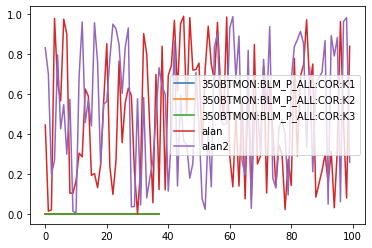

In [38]:
%matplotlib inline
import matplotlib, matplotlib.pyplot as pyplot
import ca
ch_names=(
  "350BTMON:BLM_P_ALL:COR:K1", 
  "350BTMON:BLM_P_ALL:COR:K2",
  "350BTMON:BLM_P_ALL:COR:K3",
  "alan", #softExcas
  "alan2",  #softExcas
)
channels=[ ca.channel(ch) for ch in ch_names]
channels[-1].wait_conn() # wait_for
for ch in channels: ch.autoUpdate()
ca.pend_event(0.1) # 最後のchannelが繋がれば、ほとんどの場合、それまでに作成されたチャンネルは接続ずみ
lines=[pyplot.plot(ch.val, label=ch.name)[0] for ch in channels]
#pyplot.ion()
pyplot.legend()
pyplot.draw()
pyplot.pause(0.1)